# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import sqlite3
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

nltk.download(['words', 'punkt', 'stopwords',
               'averaged_perceptron_tagger',
               'maxent_ne_chunker', 'wordnet'])

[nltk_data] Downloading package words to
[nltk_data]     /Users/ayemyatwinshwe/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ayemyatwinshwe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayemyatwinshwe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ayemyatwinshwe/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/ayemyatwinshwe/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ayemyatwinshwe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('message_category', engine)

In [3]:
df.head(2)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [4]:
# number of distinct observations
df.nunique()

id                        26180
message                   26177
original                   9630
genre                         3
related                       2
request                       2
offer                         2
aid_related                   2
medical_help                  2
medical_products              2
search_and_rescue             2
security                      2
military                      2
child_alone                   1
water                         2
food                          2
shelter                       2
clothing                      2
money                         2
missing_people                2
refugees                      2
death                         2
other_aid                     2
infrastructure_related        2
transport                     2
buildings                     2
electricity                   2
tools                         2
hospitals                     2
shops                         2
aid_centers                   2
other_in

In [5]:
# number of missing values
df.isnull().sum()

id                            0
message                       0
original                  16045
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
child_alone                   0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_in

In [6]:
# drop id, original
df.drop(['id', 'original'], axis=1, inplace=True)

In [7]:
df.head(2)

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,Weather update - a cold front from Cuba that c...,direct,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [8]:
# Check distribution of message categories
category_names = df.loc[:, 'related':'direct_report'].columns
category_counts = (df.loc[:, 'related':'direct_report']
                   ).sum().sort_values(ascending=False)

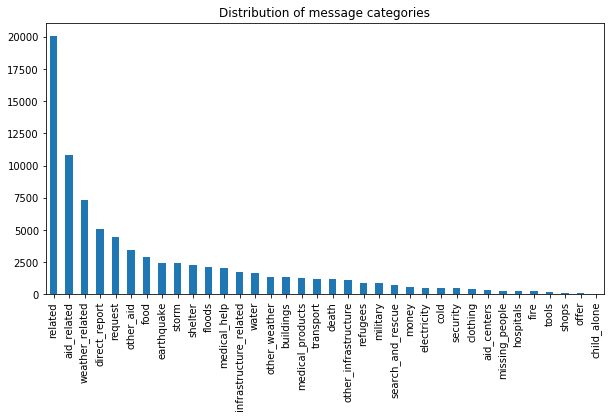

In [9]:
category_counts.plot(kind='bar', figsize=(
    10, 5), title='Distribution of message categories')

In [10]:
X = df['message'].values
Y = df.loc[:,'related':'direct_report'].values

In [11]:
# check messages and categories
rnd = np.random.randint(df.shape[0])
print(X[rnd])
df.iloc[rnd]

Two ships provided by CARE and carrying approximately 220 MT of non food items including tents for shelter, hygiene kits, medical kits, food cookers, body bags, jerry cans, sleeping mats and baby food kits were deployed to Sinabang; however due to bad weather and high sea swells could not complete their journey and are now lying off the coast of Longna awaiting calmer weather.


message                   Two ships provided by CARE and carrying approx...
genre                                                                  news
related                                                                   1
request                                                                   0
offer                                                                     0
aid_related                                                               1
medical_help                                                              1
medical_products                                                          1
search_and_rescue                                                         0
security                                                                  0
military                                                                  0
child_alone                                                               0
water                                                                     0
food        

### 2. Write a tokenization function to process your text data

In [12]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    tokens = word_tokenize(text)

    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()

    clean_tokens = [lemmatizer.lemmatize(tok)
                    for tok in tokens if tok not in stop_words]

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [13]:
pipeline_ada = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize,
                             max_features=None, max_df=1.0, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', MultiOutputClassifier(AdaBoostClassifier())),
])

In [14]:
pipeline_ada.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 2), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x1a1f3d9e60>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                      base_estimator=None,
                                                      learning_rate=1.0,
                                                      n_estimators=50,
                                                      random_state=None),
                       

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [16]:
pipeline_ada.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x1a1f3d9e60>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [17]:
Y_pred = pipeline_ada.predict(X_test)

In [18]:
(Y_pred == Y_test).mean()

0.9473001038421599

In [19]:
def display_results(y_test, y_pred, y_col):
    """
        Display f1 score, precision, recall, accuracy and confusion_matrix
        for each category of the test dataset
    """
    
    clf_report = classification_report(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = (y_pred == y_test).mean() 
    print('\n')   
    print(y_col, ":")
    print('\n')  
    print(clf_report)
    print('confusion_matrix :')
    print(confusion_mat)
    print('\n')
    print('Accuracy =', accuracy)
    print('-'*65)

In [20]:
for i in range(Y_test.shape[1]):
    display_results(Y_test[:, i], Y_pred[:, i],
                    df.loc[:, 'related':'direct_report'].columns[i])



related :


              precision    recall  f1-score   support

           0       0.68      0.26      0.38      1245
           1       0.81      0.96      0.88      3998

    accuracy                           0.80      5243
   macro avg       0.74      0.61      0.63      5243
weighted avg       0.78      0.80      0.76      5243

confusion_matrix :
[[ 325  920]
 [ 151 3847]]


Accuracy = 0.7957276368491322
-----------------------------------------------------------------


request :


              precision    recall  f1-score   support

           0       0.91      0.97      0.93      4352
           1       0.75      0.51      0.61       891

    accuracy                           0.89      5243
   macro avg       0.83      0.74      0.77      5243
weighted avg       0.88      0.89      0.88      5243

confusion_matrix :
[[4200  152]
 [ 434  457]]


Accuracy = 0.8882319282853328
-----------------------------------------------------------------


offer :


              prec



storm :


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4764
           1       0.77      0.54      0.63       479

    accuracy                           0.94      5243
   macro avg       0.86      0.76      0.80      5243
weighted avg       0.94      0.94      0.94      5243

confusion_matrix :
[[4685   79]
 [ 220  259]]


Accuracy = 0.9429715811558268
-----------------------------------------------------------------


fire :


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5190
           1       0.48      0.23      0.31        53

    accuracy                           0.99      5243
   macro avg       0.74      0.61      0.65      5243
weighted avg       0.99      0.99      0.99      5243

confusion_matrix :
[[5177   13]
 [  41   12]]


Accuracy = 0.9897005531184436
-----------------------------------------------------------------


earthquake :


              prec

### 6. Improve your model
Use grid search to find better parameters. 

In [21]:
%timeit

parameters = {

    # 'vect__max_df': [0.75, 1.0],
    # 'vect__max_features': [1000, 5000],
    # 'vect__ngram_range': [(1, 1), (1, 2)],
    # 'tfidf__smooth_idf': [True, False],
    # 'tfidf__sublinear_tf': [True, False],
    # 'tfidf__use_idf': [True, False],
    'clf__estimator__learning_rate': [0.5, 1.0],
    'clf__estimator__n_estimators': [20, 50]

}

cv_ada = GridSearchCV(pipeline_ada, param_grid=parameters,
                      cv=2, n_jobs=-1, verbose=2)

cv_ada.fit(X_train, Y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  1.4min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.4min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        prep

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [22]:
Y_pred = cv_ada.predict(X_test)

In [23]:
(Y_pred == Y_test).mean()

0.9475544111725687

In [24]:
cv_ada.get_params()

{'cv': 2,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 2), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x1a1f3d9e60>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                      base_estimator=None,
                                                      learning_rate=1.0,
                                                      n_estimators=50,
                                            

In [25]:
for i in range(Y_test.shape[1]):
    display_results(Y_test[:,i], Y_pred[:,i], df.loc[:,'related':'direct_report'].columns[i])



related :


              precision    recall  f1-score   support

           0       0.76      0.15      0.25      1245
           1       0.79      0.98      0.88      3998

    accuracy                           0.79      5243
   macro avg       0.77      0.57      0.56      5243
weighted avg       0.78      0.79      0.73      5243

confusion_matrix :
[[ 186 1059]
 [  60 3938]]


Accuracy = 0.7865725729544154
-----------------------------------------------------------------


request :


              precision    recall  f1-score   support

           0       0.89      0.98      0.94      4352
           1       0.82      0.44      0.57       891

    accuracy                           0.89      5243
   macro avg       0.85      0.71      0.75      5243
weighted avg       0.88      0.89      0.87      5243

confusion_matrix :
[[4264   88]
 [ 503  388]]


Accuracy = 0.8872782757962998
-----------------------------------------------------------------


offer :


              prec



storm :


              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4764
           1       0.79      0.43      0.55       479

    accuracy                           0.94      5243
   macro avg       0.87      0.71      0.76      5243
weighted avg       0.93      0.94      0.93      5243

confusion_matrix :
[[4709   55]
 [ 275  204]]


Accuracy = 0.9370589357238223
-----------------------------------------------------------------


fire :


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5190
           1       0.58      0.13      0.22        53

    accuracy                           0.99      5243
   macro avg       0.79      0.57      0.61      5243
weighted avg       0.99      0.99      0.99      5243

confusion_matrix :
[[5185    5]
 [  46    7]]


Accuracy = 0.9902727446118634
-----------------------------------------------------------------


earthquake :


              prec

/Users/ayemyatwinshwe/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [26]:
# Add customer transformers

def tokenize_2(text):
    
        detected_urls = re.findall(url_regex, text)
        for url in detected_urls:
            text = text.replace(url, "urlplaceholder")

        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        clean_tokens = [lemmatizer.lemmatize(tok).lower().strip() for tok in tokens]

        return clean_tokens
    
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize_2(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)
    
# Count the number of tokens

class TextLengthExtractor(BaseEstimator, TransformerMixin):

    def text_len_count(self, text):

        text_length = len(tokenize(text))

        return text_length

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_text_len = pd.Series(X).apply(self.text_len_count)
        return pd.DataFrame(X_text_len)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d9f6510>]],
      dtype=object)

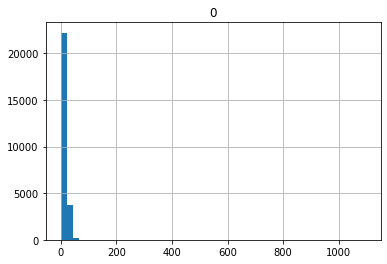

In [27]:
TextLengthExtractor().transform(X).hist(bins=50)

In [28]:
pipeline_xgb = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize,
                                     max_features=6000,
                                     max_df=0.75)),
            ('tfidf', TfidfTransformer(use_idf=True))
        ])),

        ('txt_length', TextLengthExtractor()),
        ('start_verb', StartingVerbExtractor())
    ])),

    ('norm',  Normalizer()),

    ('clf', MultiOutputClassifier(XGBClassifier(
        max_depth=3,
        learning_rate=0.2,
        max_delta_step=2,
        colsample_bytree=0.7,
        colsample_bylevel=0.7,
        subsample=0.8,
        n_estimators=150,
        tree_method='hist',
    )))
])

In [29]:
pipeline_xgb.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [30]:
Y_pred = pipeline_xgb.predict(X_test)

In [31]:
(Y_pred == Y_test).mean()

0.9515544535571238

In [32]:
for i in range(Y_test.shape[1]):
    display_results(Y_test[:, i], Y_pred[:, i],
                    df.loc[:, 'related':'direct_report'].columns[i])



related :


              precision    recall  f1-score   support

           0       0.72      0.39      0.50      1245
           1       0.83      0.95      0.89      3998

    accuracy                           0.82      5243
   macro avg       0.78      0.67      0.70      5243
weighted avg       0.81      0.82      0.80      5243

confusion_matrix :
[[ 482  763]
 [ 185 3813]]


Accuracy = 0.8191874880793439
-----------------------------------------------------------------


request :


              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4352
           1       0.84      0.53      0.65       891

    accuracy                           0.90      5243
   macro avg       0.87      0.75      0.80      5243
weighted avg       0.90      0.90      0.89      5243

confusion_matrix :
[[4259   93]
 [ 419  472]]


Accuracy = 0.9023459851230212
-----------------------------------------------------------------


offer :


              prec

/Users/ayemyatwinshwe/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




shelter :


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4775
           1       0.77      0.59      0.67       468

    accuracy                           0.95      5243
   macro avg       0.86      0.79      0.82      5243
weighted avg       0.94      0.95      0.94      5243

confusion_matrix :
[[4692   83]
 [ 192  276]]


Accuracy = 0.9475491131031852
-----------------------------------------------------------------


clothing :


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5173
           1       0.73      0.46      0.56        70

    accuracy                           0.99      5243
   macro avg       0.86      0.73      0.78      5243
weighted avg       0.99      0.99      0.99      5243

confusion_matrix :
[[5161   12]
 [  38   32]]


Accuracy = 0.99046347510967
-----------------------------------------------------------------


money :


              preci

### 9. Export your model as a pickle file

In [33]:
import pickle
pickle.dump(pipeline_xgb,open('./models/model_xgb','wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.